<a href="https://colab.research.google.com/github/yenngocduong/Sign-language-interpreter/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

# Load Data

In [ ]:
import pickle
data_path = '/content/drive/MyDrive/Colab Notebooks/EE8101/datasets.pkl'
data_input = open(data_path, 'rb')
read_data = pickle.load(data_input)
data_input.close()

a = read_data[0][0]
a.shape

(28, 2, 21, 3)

In [ ]:
list_train = read_data[0]
list_dev = read_data[1]
list_test = read_data[2]
y_train = read_data[3]
y_dev = read_data[4]
y_test = read_data[5]

# Model

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters
input_size = 2 * 21 * 3
hidden_size = 128
num_layers = 2
num_epochs = 50
batch_size = 16
learning_rate = 0.001
seq_len = 8

#num_classes
num_classes = 111

In [ ]:
from torch.utils.data import Dataset, DataLoader
import random

def seq_len_filter(m, seq_len):
  b_len = m.shape[0]
  lucky_index = []
  for i in range(seq_len):
    lucky_index.append(random.randint(0, b_len-1))
  lucky_index.sort()

  new_m = m[lucky_index]
  new_m = new_m.reshape((seq_len, -1))
  return new_m

class Seq_len_dataset(Dataset):
  def __init__(self, list_of_arrays, y, seq_len):
    self.list_of_arrays = list_of_arrays
    self.y = y
    self.seq_len = seq_len

  def __len__(self):
    return len(self.list_of_arrays)
  
  def __getitem__(self, idx):
    array = self.list_of_arrays[idx]
    array = seq_len_filter(array, self.seq_len)
    label = self.y[idx]
    return (array, label)
 
train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)
test_dataset = Seq_len_dataset(list_test, y_test, seq_len)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
def topk_correct(outputs, labels, topk):
  correct = 0
  outputs = outputs.topk(topk, dim = -1).indices
  for i, label in enumerate(labels):
    # print(outputs[i])
    if label in outputs[i]:
      
      correct += 1
  return correct


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.foc = nn.Linear((hidden_size), (num_classes))

    def forward(self, x):
        x, h_n = self.gru(x)
        output = self.foc(h_n[-1])
        return output

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
losses = []
train_accs = []
dev_accs = []
dev_accs_top3 = []
dev_accs_top10 = []

print_loss_every_step = 20

for epoch in range(num_epochs):

    for i, (arrays, labels) in enumerate(train_loader):
        
        labels = labels.to(torch.long).to(device)
        arrays = arrays.to(device)

        # Forward pass
        outputs = model(arrays)
        loss = criterion(outputs, labels)
        losses.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % print_loss_every_step == 0:
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
    
    with torch.no_grad():
        total = 0
        total_correct = 0
        for i, (arrays, labels) in enumerate(train_loader):
            labels = labels.to(torch.long).to(device)
            arrays = arrays.to(device)
            # Forward pass
            outputs = model(arrays)
            outputs = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(outputs)
            total_correct += (outputs == labels).sum().item()

        train_acc = total_correct / total
        train_accs.append(train_acc)

        print(f"train Accuracy: {total_correct / total * 100:.2f}")

    with torch.no_grad():
        total = 0
        total_correct = 0
        total_top3_correct = 0
        total_top10_correct = 0
        for i, (arrays, labels) in enumerate(dev_loader):
            labels = labels.to(torch.long).to(device)
            arrays = arrays.to(device)
            # Forward pass
            outputs = model(arrays)
            preds = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(preds)
            total_correct += (preds == labels).sum().item()
            total_top3_correct += topk_correct(outputs, labels, 3)
            total_top10_correct += topk_correct(outputs, labels, 10)


        dev_acc = total_correct / total
        dev_accs.append(dev_acc)
        dev_accs_top3.append(total_top3_correct / total)
        dev_accs_top10.append(total_top10_correct / total)

        print(f"dev Accuracy: {total_correct / total * 100:.2f}")
        print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
        print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

Epoch [1/50], Step [20], Loss: 4.6190
Epoch [1/50], Step [40], Loss: 4.5559
Epoch [1/50], Step [60], Loss: 4.2405
Epoch [1/50], Step [80], Loss: 4.4247
train Accuracy: 2.80
dev Accuracy: 0.75
dev top 3 Accuracy: 3.02
dev top 10 Accuracy: 18.49
Epoch [2/50], Step [20], Loss: 4.6852
Epoch [2/50], Step [40], Loss: 4.2481
Epoch [2/50], Step [60], Loss: 4.1649
Epoch [2/50], Step [80], Loss: 4.4683
train Accuracy: 3.94
dev Accuracy: 3.77
dev top 3 Accuracy: 10.19
dev top 10 Accuracy: 27.17
Epoch [3/50], Step [20], Loss: 4.3380
Epoch [3/50], Step [40], Loss: 4.0988
Epoch [3/50], Step [60], Loss: 4.3758
Epoch [3/50], Step [80], Loss: 4.0593
train Accuracy: 5.60
dev Accuracy: 3.02
dev top 3 Accuracy: 9.06
dev top 10 Accuracy: 30.57
Epoch [4/50], Step [20], Loss: 3.9481
Epoch [4/50], Step [40], Loss: 4.2358
Epoch [4/50], Step [60], Loss: 3.9742
Epoch [4/50], Step [80], Loss: 4.2955
train Accuracy: 6.07
dev Accuracy: 6.04
dev top 3 Accuracy: 12.45
dev top 10 Accuracy: 32.08
Epoch [5/50], Step [20

Text(0.5, 1.0, 'train loss')

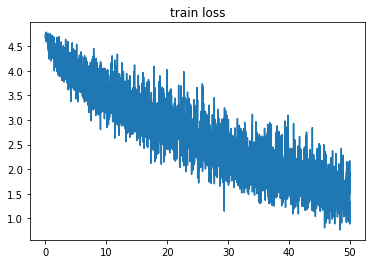

In [ ]:
import matplotlib.pyplot as plt

a = np.arange(len(losses))
a = a / len(train_loader)

plt.plot(a, losses)
plt.title('train loss')

Text(0.5, 1.0, 'train and dev accuracy')

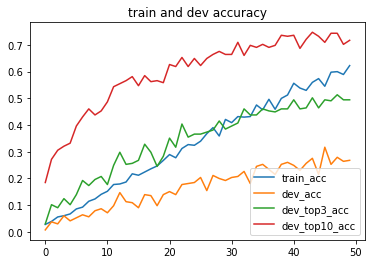

In [ ]:
plt.plot(train_accs, label = 'train_acc')
plt.plot(dev_accs, label = 'dev_acc')
plt.plot(dev_accs_top3, label = 'dev_top3_acc')
plt.plot(dev_accs_top10, label = 'dev_top10_acc')
plt.legend()
plt.title('train and dev accuracy')

# HP: seq_len

In [ ]:
seq_lens = [2, 4, 8, 16, 32, 64]

input_size = 2 * 21 * 3
hidden_size = 128
num_layers = 2
num_epochs = 100
batch_size = 16
learning_rate = 0.001

In [ ]:
train_accs_list = []
dev_accs_list = []
dev_accs_top3_list = []
dev_accs_top10_list = []

for seq_len in seq_lens:
  print(seq_len)
  train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
  dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

  model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []

  print_loss_every_step = 20

  for epoch in range(num_epochs):
      print('seq_len ', str(seq_len), 'epoch ', str(epoch + 1), '/100')

      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)
          arrays = arrays.to(device)

          # Forward pass
          outputs = model(arrays)
          loss = criterion(outputs, labels)
          # losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # if (i+1) % print_loss_every_step == 0:
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  train_accs_list.append(train_accs)
  dev_accs_list.append(dev_accs)
  dev_accs_top3_list.append(dev_accs_top3)
  dev_accs_top10_list.append(dev_accs_top10)


2
seq_len  2 epoch  1 /100
train Accuracy: 1.53
dev Accuracy: 1.51
dev top 3 Accuracy: 3.40
dev top 10 Accuracy: 13.96
seq_len  2 epoch  2 /100
train Accuracy: 4.27
dev Accuracy: 4.15
dev top 3 Accuracy: 8.68
dev top 10 Accuracy: 21.13
seq_len  2 epoch  3 /100
train Accuracy: 3.60
dev Accuracy: 3.40
dev top 3 Accuracy: 6.42
dev top 10 Accuracy: 20.38
seq_len  2 epoch  4 /100
train Accuracy: 4.14
dev Accuracy: 3.40
dev top 3 Accuracy: 7.92
dev top 10 Accuracy: 24.91
seq_len  2 epoch  5 /100
train Accuracy: 4.67
dev Accuracy: 4.15
dev top 3 Accuracy: 11.32
dev top 10 Accuracy: 31.32
seq_len  2 epoch  6 /100
train Accuracy: 6.00
dev Accuracy: 3.40
dev top 3 Accuracy: 9.43
dev top 10 Accuracy: 31.32
seq_len  2 epoch  7 /100
train Accuracy: 6.40
dev Accuracy: 3.02
dev top 3 Accuracy: 10.57
dev top 10 Accuracy: 35.85
seq_len  2 epoch  8 /100
train Accuracy: 7.27
dev Accuracy: 4.15
dev top 3 Accuracy: 13.58
dev top 10 Accuracy: 39.62
seq_len  2 epoch  9 /100
train Accuracy: 10.41
dev Accuracy

Text(0.5, 0.98, 'seq_len')

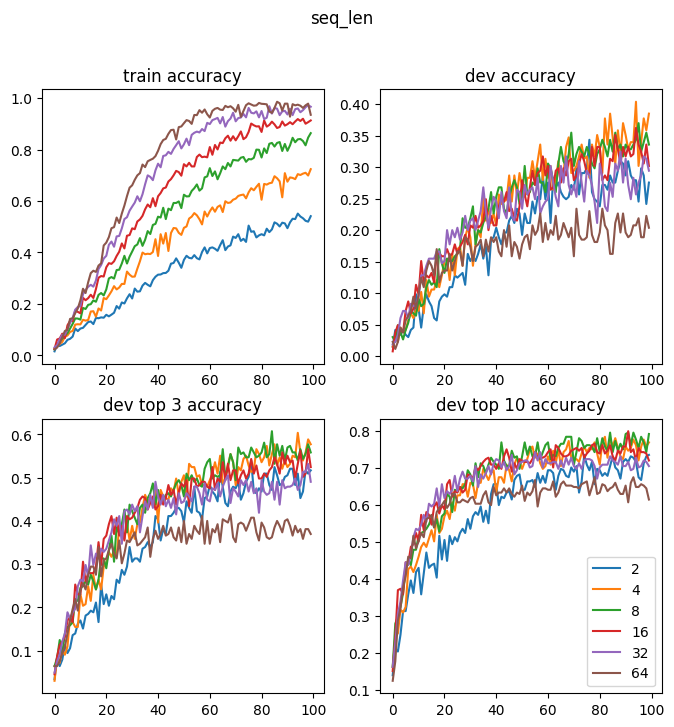

In [ ]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()



for i, seq_len in enumerate(seq_lens):
  ax[0].plot(train_accs_list[i], label = str(seq_len))
  ax[1].plot(dev_accs_list[i], label = str(seq_len))
  ax[2].plot(dev_accs_top3_list[i], label = str(seq_len))
  ax[3].plot(dev_accs_top10_list[i], label = str(seq_len))
  


ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')
plt.legend()

figure.suptitle('seq_len')

# HP: hidden_size

In [ ]:
seq_len = 8

hidden_sizes = [32, 64, 128, 256, 512, 1024]


num_layers = 2
num_epochs = 100
batch_size = 16
learning_rate = 0.001

In [ ]:
train_accs_list = []
dev_accs_list = []
dev_accs_top3_list = []
dev_accs_top10_list = []

for hidden_size in hidden_sizes:
  print(hidden_size)
  train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
  dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

  model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []


  for epoch in range(num_epochs):
      print('hidden_size ', str(hidden_size), 'epoch ', str(epoch + 1), '/100')

      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)
          arrays = arrays.to(device)

          # Forward pass
          outputs = model(arrays)
          loss = criterion(outputs, labels)
          # losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # if (i+1) % print_loss_every_step == 0:
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  train_accs_list.append(train_accs)
  dev_accs_list.append(dev_accs)
  dev_accs_top3_list.append(dev_accs_top3)
  dev_accs_top10_list.append(dev_accs_top10)


32
hidden_size  32 epoch  1 /100
train Accuracy: 3.20
dev Accuracy: 1.51
dev top 3 Accuracy: 5.28
dev top 10 Accuracy: 15.47
hidden_size  32 epoch  2 /100
train Accuracy: 3.27
dev Accuracy: 1.51
dev top 3 Accuracy: 5.66
dev top 10 Accuracy: 15.09
hidden_size  32 epoch  3 /100
train Accuracy: 4.47
dev Accuracy: 2.64
dev top 3 Accuracy: 6.04
dev top 10 Accuracy: 20.38
hidden_size  32 epoch  4 /100
train Accuracy: 5.27
dev Accuracy: 2.64
dev top 3 Accuracy: 7.92
dev top 10 Accuracy: 23.02
hidden_size  32 epoch  5 /100
train Accuracy: 4.94
dev Accuracy: 2.64
dev top 3 Accuracy: 6.04
dev top 10 Accuracy: 25.66
hidden_size  32 epoch  6 /100
train Accuracy: 4.67
dev Accuracy: 3.40
dev top 3 Accuracy: 8.30
dev top 10 Accuracy: 30.94
hidden_size  32 epoch  7 /100
train Accuracy: 5.40
dev Accuracy: 1.89
dev top 3 Accuracy: 7.17
dev top 10 Accuracy: 30.57
hidden_size  32 epoch  8 /100
train Accuracy: 5.94
dev Accuracy: 3.77
dev top 3 Accuracy: 10.19
dev top 10 Accuracy: 29.81
hidden_size  32 epoc

Text(0.5, 0.98, 'hidden_size')

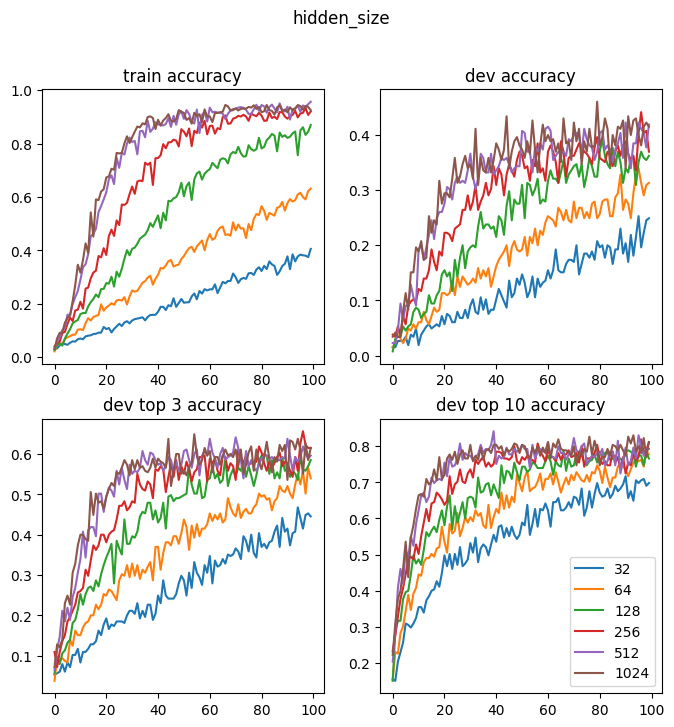

In [ ]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()



for i, hidden_size in enumerate(hidden_sizes):
  ax[0].plot(train_accs_list[i], label = str(hidden_size))
  ax[1].plot(dev_accs_list[i], label = str(hidden_size))
  ax[2].plot(dev_accs_top3_list[i], label = str(hidden_size))
  ax[3].plot(dev_accs_top10_list[i], label = str(hidden_size))
  


ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')
plt.legend()

figure.suptitle('hidden_size')

# HP: num_layers

In [ ]:
seq_len = 8
hidden_size = 512

num_layers_ = [1, 2, 3, 4, 5, 6]

num_epochs = 100
batch_size = 16
learning_rate = 0.001

In [ ]:
train_accs_list = []
dev_accs_list = []
dev_accs_top3_list = []
dev_accs_top10_list = []

for num_layers in num_layers_:
  print(num_layers)
  train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
  dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

  model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []


  for epoch in range(num_epochs):
      print('num_layers ', str(num_layers), 'epoch ', str(epoch + 1), '/100')

      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)
          arrays = arrays.to(device)

          # Forward pass
          outputs = model(arrays)
          loss = criterion(outputs, labels)
          # losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # if (i+1) % print_loss_every_step == 0:
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  train_accs_list.append(train_accs)
  dev_accs_list.append(dev_accs)
  dev_accs_top3_list.append(dev_accs_top3)
  dev_accs_top10_list.append(dev_accs_top10)


1
num_layers  1 epoch  1 /100
train Accuracy: 3.40
dev Accuracy: 1.89
dev top 3 Accuracy: 4.91
dev top 10 Accuracy: 21.13
num_layers  1 epoch  2 /100
train Accuracy: 5.20
dev Accuracy: 2.64
dev top 3 Accuracy: 7.17
dev top 10 Accuracy: 27.55
num_layers  1 epoch  3 /100
train Accuracy: 7.40
dev Accuracy: 4.53
dev top 3 Accuracy: 10.94
dev top 10 Accuracy: 32.83
num_layers  1 epoch  4 /100
train Accuracy: 8.34
dev Accuracy: 5.28
dev top 3 Accuracy: 13.58
dev top 10 Accuracy: 37.74
num_layers  1 epoch  5 /100
train Accuracy: 10.81
dev Accuracy: 7.17
dev top 3 Accuracy: 17.36
dev top 10 Accuracy: 46.42
num_layers  1 epoch  6 /100
train Accuracy: 12.21
dev Accuracy: 9.06
dev top 3 Accuracy: 19.62
dev top 10 Accuracy: 45.66
num_layers  1 epoch  7 /100
train Accuracy: 14.54
dev Accuracy: 11.70
dev top 3 Accuracy: 22.64
dev top 10 Accuracy: 47.17
num_layers  1 epoch  8 /100
train Accuracy: 16.08
dev Accuracy: 10.19
dev top 3 Accuracy: 22.26
dev top 10 Accuracy: 51.32
num_layers  1 epoch  9 /10

Text(0.5, 0.98, 'num_layers')

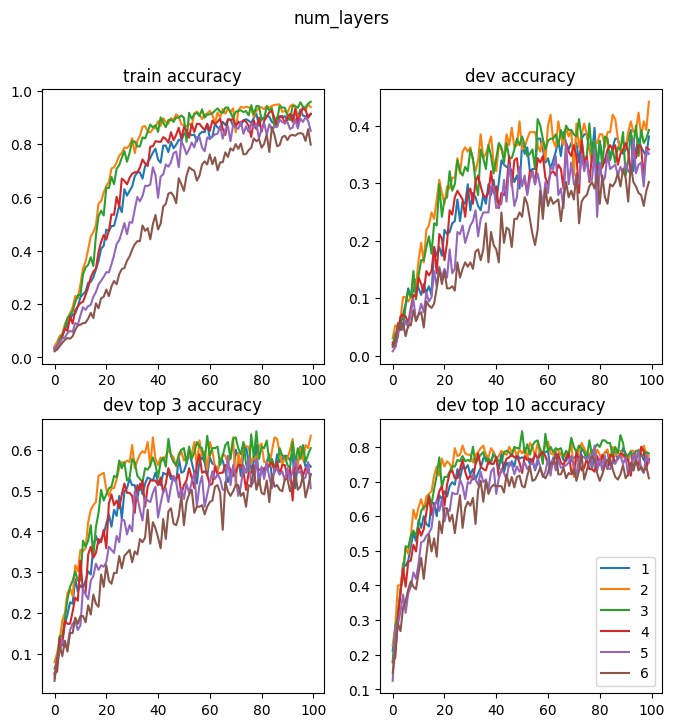

In [ ]:
figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()


for i,num_layers in enumerate(num_layers_):
  ax[0].plot(train_accs_list[i], label = str(num_layers))
  ax[1].plot(dev_accs_list[i], label = str(num_layers))
  ax[2].plot(dev_accs_top3_list[i], label = str(num_layers))
  ax[3].plot(dev_accs_top10_list[i], label = str(num_layers))
  


ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')
plt.legend()

figure.suptitle('num_layers')

# HP: batch_size

In [ ]:
seq_len = 8
hidden_size = 512
num_layers_ = 2
num_epochs = 60

batch_sizes = [4, 8, 16, 32, 64, 128]

learning_rate = 0.001

In [ ]:
train_accs_list = []
dev_accs_list = []
dev_accs_top3_list = []
dev_accs_top10_list = []

for batch_size in batch_sizes:
  print(batch_size)
  train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
  dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

  model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []


  for epoch in range(num_epochs):
      print('batch_size ', str(batch_size), 'epoch ', str(epoch + 1), '/', str(num_epochs))

      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)
          arrays = arrays.to(device)

          # Forward pass
          outputs = model(arrays)
          loss = criterion(outputs, labels)
          # losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # if (i+1) % print_loss_every_step == 0:
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  train_accs_list.append(train_accs)
  dev_accs_list.append(dev_accs)
  dev_accs_top3_list.append(dev_accs_top3)
  dev_accs_top10_list.append(dev_accs_top10)


4
batch_size  4 epoch  1 / 60
train Accuracy: 2.07
dev Accuracy: 0.38
dev top 3 Accuracy: 3.02
dev top 10 Accuracy: 14.34
batch_size  4 epoch  2 / 60
train Accuracy: 2.60
dev Accuracy: 1.13
dev top 3 Accuracy: 2.26
dev top 10 Accuracy: 12.83
batch_size  4 epoch  3 / 60
train Accuracy: 2.87
dev Accuracy: 1.89
dev top 3 Accuracy: 4.91
dev top 10 Accuracy: 17.74
batch_size  4 epoch  4 / 60
train Accuracy: 2.47
dev Accuracy: 2.26
dev top 3 Accuracy: 6.79
dev top 10 Accuracy: 15.47
batch_size  4 epoch  5 / 60
train Accuracy: 4.14
dev Accuracy: 2.26
dev top 3 Accuracy: 9.06
dev top 10 Accuracy: 21.51
batch_size  4 epoch  6 / 60
train Accuracy: 2.80
dev Accuracy: 2.26
dev top 3 Accuracy: 9.06
dev top 10 Accuracy: 23.77
batch_size  4 epoch  7 / 60
train Accuracy: 3.07
dev Accuracy: 3.02
dev top 3 Accuracy: 9.81
dev top 10 Accuracy: 25.66
batch_size  4 epoch  8 / 60
train Accuracy: 3.87
dev Accuracy: 3.77
dev top 3 Accuracy: 7.17
dev top 10 Accuracy: 26.42
batch_size  4 epoch  9 / 60
train Accu

Text(0.5, 0.98, 'batch_size')

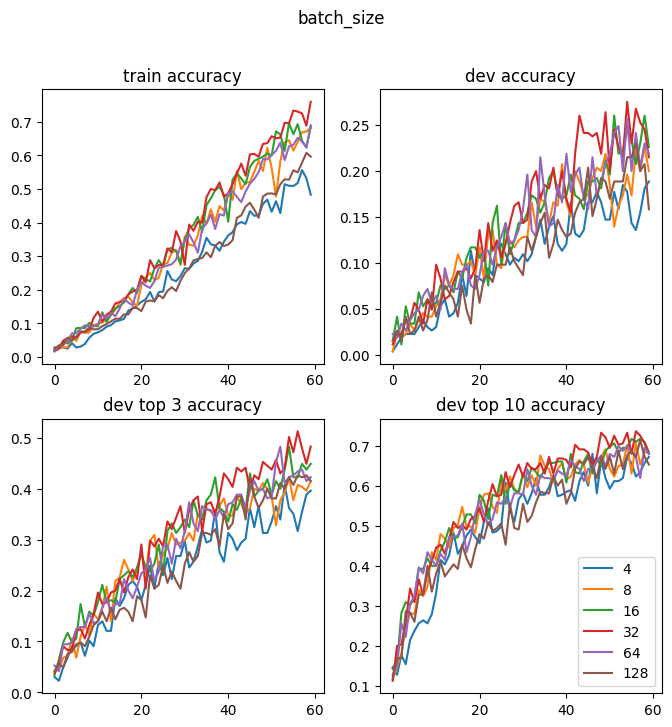

In [ ]:


figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()



for i, batch_size in enumerate(batch_sizes):
  ax[0].plot(train_accs_list[i], label = str(batch_size))
  ax[1].plot(dev_accs_list[i], label = str(batch_size))
  ax[2].plot(dev_accs_top3_list[i], label = str(batch_size))
  ax[3].plot(dev_accs_top10_list[i], label = str(batch_size))
  


ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')
plt.legend()

figure.suptitle('batch_size')

# HP: learning_rate

In [ ]:
seq_len = 8
hidden_size = 512
num_layers_ = 2
num_epochs = 100
batch_sizes = 32

learning_rates = [0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

In [ ]:
train_accs_list = []
dev_accs_list = []
dev_accs_top3_list = []
dev_accs_top10_list = []

for learning_rate in learning_rates:
  print(learning_rate)
  train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
  dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

  model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []


  for epoch in range(num_epochs):
      print('learning_rate ', str(learning_rate), 'epoch ', str(epoch + 1), '/', str(num_epochs))

      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)
          arrays = arrays.to(device)

          # Forward pass
          outputs = model(arrays)
          loss = criterion(outputs, labels)
          # losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # if (i+1) % print_loss_every_step == 0:
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  train_accs_list.append(train_accs)
  dev_accs_list.append(dev_accs)
  dev_accs_top3_list.append(dev_accs_top3)
  dev_accs_top10_list.append(dev_accs_top10)


0.0003
learning_rate  0.0003 epoch  1 / 100
train Accuracy: 2.94
dev Accuracy: 1.13
dev top 3 Accuracy: 4.53
dev top 10 Accuracy: 13.58
learning_rate  0.0003 epoch  2 / 100
train Accuracy: 4.54
dev Accuracy: 3.02
dev top 3 Accuracy: 9.81
dev top 10 Accuracy: 27.92
learning_rate  0.0003 epoch  3 / 100
train Accuracy: 4.87
dev Accuracy: 1.89
dev top 3 Accuracy: 9.43
dev top 10 Accuracy: 28.68
learning_rate  0.0003 epoch  4 / 100
train Accuracy: 6.94
dev Accuracy: 7.17
dev top 3 Accuracy: 15.47
dev top 10 Accuracy: 40.38
learning_rate  0.0003 epoch  5 / 100
train Accuracy: 8.21
dev Accuracy: 6.04
dev top 3 Accuracy: 13.58
dev top 10 Accuracy: 40.00
learning_rate  0.0003 epoch  6 / 100
train Accuracy: 9.61
dev Accuracy: 5.66
dev top 3 Accuracy: 16.60
dev top 10 Accuracy: 45.66
learning_rate  0.0003 epoch  7 / 100
train Accuracy: 11.14
dev Accuracy: 7.17
dev top 3 Accuracy: 15.09
dev top 10 Accuracy: 39.62
learning_rate  0.0003 epoch  8 / 100
train Accuracy: 12.68
dev Accuracy: 8.30
dev top

Text(0.5, 0.98, 'learning_rate')

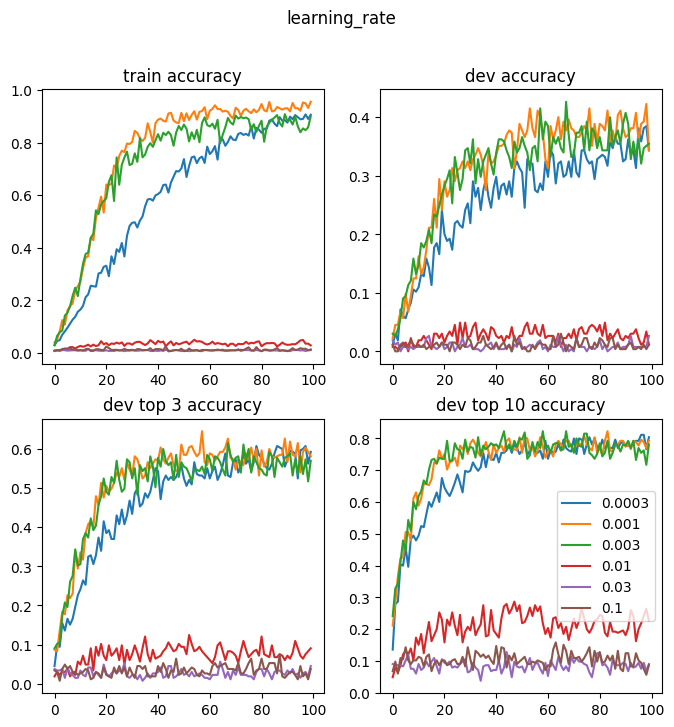

In [ ]:
figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()



for i, learning_rate in enumerate(learning_rates):
  ax[0].plot(train_accs_list[i], label = str(learning_rate))
  ax[1].plot(dev_accs_list[i], label = str(learning_rate))
  ax[2].plot(dev_accs_top3_list[i], label = str(learning_rate))
  ax[3].plot(dev_accs_top10_list[i], label = str(learning_rate))
  


ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')

plt.legend()

figure.suptitle('learning_rate')

In [ ]:
seq_len = 8
hidden_size = 512
num_layers_ = 2
num_epochs = 150
batch_sizes = 32

learning_rate = 0.003

losses = []
train_accs = []
dev_accs = []
dev_accs_top3 = []
dev_accs_top10 = []

print_loss_every_step = 20

lr_decay_every = 25
lr_decay = 0.3

model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


for epoch in range(num_epochs):


    if (i+1) % lr_decay_every == 0:
      learning_rate = learning_rate * lr_decay
      optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    

    

    for i, (arrays, labels) in enumerate(train_loader):
        
        labels = labels.to(torch.long).to(device)
        arrays = arrays.to(device)

        # Forward pass
        outputs = model(arrays)
        loss = criterion(outputs, labels)
        losses.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % print_loss_every_step == 0:
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
    
    with torch.no_grad():
        total = 0
        total_correct = 0
        for i, (arrays, labels) in enumerate(train_loader):
            labels = labels.to(torch.long).to(device)
            arrays = arrays.to(device)
            # Forward pass
            outputs = model(arrays)
            outputs = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(outputs)
            total_correct += (outputs == labels).sum().item()

        train_acc = total_correct / total
        train_accs.append(train_acc)

        print(f"train Accuracy: {total_correct / total * 100:.2f}")

    with torch.no_grad():
        total = 0
        total_correct = 0
        total_top3_correct = 0
        total_top10_correct = 0
        for i, (arrays, labels) in enumerate(dev_loader):
            labels = labels.to(torch.long).to(device)
            arrays = arrays.to(device)
            # Forward pass
            outputs = model(arrays)
            preds = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(preds)
            total_correct += (preds == labels).sum().item()
            total_top3_correct += topk_correct(outputs, labels, 3)
            total_top10_correct += topk_correct(outputs, labels, 10)


        dev_acc = total_correct / total
        dev_accs.append(dev_acc)
        dev_accs_top3.append(total_top3_correct / total)
        dev_accs_top10.append(total_top10_correct / total)

        print(f"dev Accuracy: {total_correct / total * 100:.2f}")
        print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
        print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

Epoch [1/150], Step [20], Loss: 4.8749
Epoch [1/150], Step [40], Loss: 4.4799
Epoch [1/150], Step [60], Loss: 4.4192
Epoch [1/150], Step [80], Loss: 4.6339
train Accuracy: 3.40
dev Accuracy: 3.40
dev top 3 Accuracy: 9.43
dev top 10 Accuracy: 28.30
Epoch [2/150], Step [20], Loss: 4.2101
Epoch [2/150], Step [40], Loss: 3.9774
Epoch [2/150], Step [60], Loss: 4.3837
Epoch [2/150], Step [80], Loss: 4.5659
train Accuracy: 5.34
dev Accuracy: 3.02
dev top 3 Accuracy: 12.45
dev top 10 Accuracy: 35.09
Epoch [3/150], Step [20], Loss: 4.0420
Epoch [3/150], Step [40], Loss: 3.9825
Epoch [3/150], Step [60], Loss: 4.1321
Epoch [3/150], Step [80], Loss: 3.7177
train Accuracy: 8.41
dev Accuracy: 6.04
dev top 3 Accuracy: 14.72
dev top 10 Accuracy: 36.60
Epoch [4/150], Step [20], Loss: 3.7392
Epoch [4/150], Step [40], Loss: 3.9373
Epoch [4/150], Step [60], Loss: 4.4195
Epoch [4/150], Step [80], Loss: 3.8634
train Accuracy: 12.01
dev Accuracy: 7.55
dev top 3 Accuracy: 14.72
dev top 10 Accuracy: 46.42
Epoc

Text(0.5, 1.0, 'train loss')

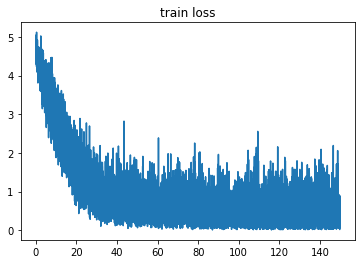

In [ ]:
a = np.arange(len(losses))
a = a / len(train_loader)

plt.plot(a, losses)
plt.title('train loss')

Text(0.5, 1.0, 'train and dev accuracy')

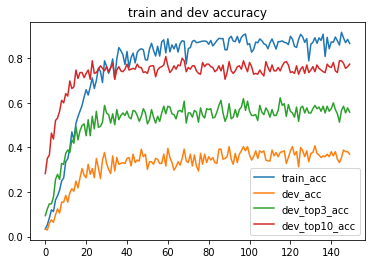

In [ ]:
plt.plot(train_accs, label = 'train_acc')
plt.plot(dev_accs, label = 'dev_acc')
plt.plot(dev_accs_top3, label = 'dev_top3_acc')
plt.plot(dev_accs_top10, label = 'dev_top10_acc')
plt.legend()
plt.title('train and dev accuracy')

# HP: bi-directional

In [ ]:
def train(num_epochs):

  losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    
  for epoch in range(num_epochs):


      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)
          arrays = arrays.to(device)

          # Forward pass
          outputs = model(arrays)

          loss = criterion(outputs, labels)
          losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if (i+1) % print_loss_every_step == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  return   losses, train_accs, dev_accs, dev_accs_top3, dev_accs_top10 

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional = True):
        super(RNN, self).__init__()
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        if bidirectional == True:
          self.n_directions = 2
        else:
          self.n_directions = 1

        self.foc = nn.Linear((hidden_size * self.n_directions), (num_classes))

    def forward(self, x):
        x, h_n = self.gru(x)

        if self.n_directions == 2:
          hidden_cat = torch.cat([h_n[-1], h_n[-2]], dim = 1)
        else:
          hidden_cat = h_n[-1]

        output = self.foc(hidden_cat)
        return output

In [ ]:
seq_len = 8
hidden_size = 512
num_layers_ = 2
num_epochs = 100
batch_sizes = 32

learning_rate = 0.001

model = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional = False).double().to(device)
single = train(num_epochs)

model = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional = True).double().to(device)
bi = train(num_epochs)

Epoch [1/100], Step [20], Loss: 4.8255
Epoch [1/100], Step [40], Loss: 4.4031
Epoch [1/100], Step [60], Loss: 4.0608
Epoch [1/100], Step [80], Loss: 4.4821
train Accuracy: 3.60
dev Accuracy: 2.26
dev top 3 Accuracy: 8.68
dev top 10 Accuracy: 21.13
Epoch [2/100], Step [20], Loss: 4.7014
Epoch [2/100], Step [40], Loss: 4.0801
Epoch [2/100], Step [60], Loss: 4.1193
Epoch [2/100], Step [80], Loss: 4.2888
train Accuracy: 6.07
dev Accuracy: 4.15
dev top 3 Accuracy: 13.58
dev top 10 Accuracy: 27.92
Epoch [3/100], Step [20], Loss: 4.0542
Epoch [3/100], Step [40], Loss: 4.0681
Epoch [3/100], Step [60], Loss: 3.9804
Epoch [3/100], Step [80], Loss: 3.8239
train Accuracy: 8.47
dev Accuracy: 5.66
dev top 3 Accuracy: 16.98
dev top 10 Accuracy: 35.47
Epoch [4/100], Step [20], Loss: 3.9327
Epoch [4/100], Step [40], Loss: 3.7075
Epoch [4/100], Step [60], Loss: 4.0373
Epoch [4/100], Step [80], Loss: 3.7709
train Accuracy: 10.27
dev Accuracy: 9.06
dev top 3 Accuracy: 18.49
dev top 10 Accuracy: 44.91
Epoc

Text(0.5, 0.98, 'learning_rate')

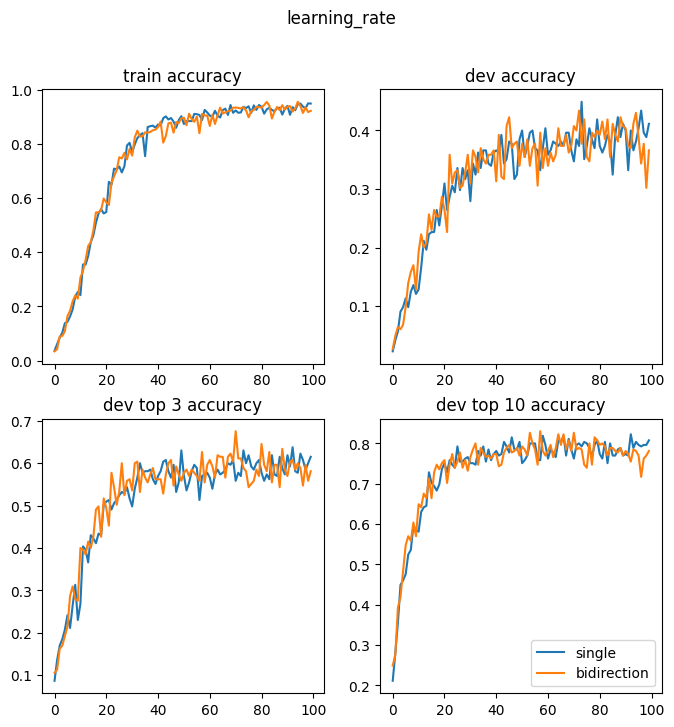

In [ ]:
figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()




ax[0].plot(single[1], label = 'single')
ax[1].plot(single[2], label = 'single')
ax[2].plot(single[3], label = 'single')
ax[3].plot(single[4], label = 'single')

ax[0].plot(bi[1], label = 'bidirection')
ax[1].plot(bi[2], label = 'bidirection')
ax[2].plot(bi[3], label = 'bidirection')
ax[3].plot(bi[4], label = 'bidirection')


ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')

plt.legend()

figure.suptitle('learning_rate')

# type of rnn

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.foc = nn.Linear((hidden_size), (num_classes))

    def forward(self, x):
        x, h_n = self.rnn(x)
        output = self.foc(h_n[-1])
        return output

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.foc = nn.Linear((hidden_size), (num_classes))

    def forward(self, x):
        x, h_n = self.rnn(x)
        output = self.foc(h_n[-1])
        return output

In [ ]:
seq_len = 8
hidden_size = 512
num_layers_ = 2
num_epochs = 100
batch_sizes = 32

learning_rate = 0.001

model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
rnn = train(num_epochs)

model = GRU(input_size, hidden_size, num_layers, num_classes).double().to(device)
gru = train(num_epochs)

model = LSTM(input_size, hidden_size, num_layers, num_classes).double().to(device)
lstm = train(num_epochs)

Epoch [1/100], Step [20], Loss: 4.6850
Epoch [1/100], Step [40], Loss: 4.8726
Epoch [1/100], Step [60], Loss: 5.0417
Epoch [1/100], Step [80], Loss: 4.9128
train Accuracy: 2.60
dev Accuracy: 1.13
dev top 3 Accuracy: 3.02
dev top 10 Accuracy: 14.72
Epoch [2/100], Step [20], Loss: 4.6930
Epoch [2/100], Step [40], Loss: 4.1412
Epoch [2/100], Step [60], Loss: 4.6900
Epoch [2/100], Step [80], Loss: 4.6289
train Accuracy: 3.47
dev Accuracy: 2.64
dev top 3 Accuracy: 6.42
dev top 10 Accuracy: 21.89
Epoch [3/100], Step [20], Loss: 3.8908
Epoch [3/100], Step [40], Loss: 4.2853
Epoch [3/100], Step [60], Loss: 4.8161
Epoch [3/100], Step [80], Loss: 4.6355
train Accuracy: 4.14
dev Accuracy: 2.64
dev top 3 Accuracy: 6.42
dev top 10 Accuracy: 24.91
Epoch [4/100], Step [20], Loss: 4.3746
Epoch [4/100], Step [40], Loss: 4.6699
Epoch [4/100], Step [60], Loss: 4.3801
Epoch [4/100], Step [80], Loss: 4.3729
train Accuracy: 4.27
dev Accuracy: 6.42
dev top 3 Accuracy: 12.08
dev top 10 Accuracy: 29.43
Epoch [

ValueError: ignored

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.foc = nn.Linear((hidden_size), (num_classes))

    def forward(self, x):
        h_n, c_n = self.rnn(x)
        output = self.foc(h_n[:, -1])
        return output

In [ ]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).double().to(device)
lstm = train(num_epochs)

Epoch [1/100], Step [20], Loss: 4.6859
Epoch [1/100], Step [40], Loss: 4.4571
Epoch [1/100], Step [60], Loss: 4.5313
Epoch [1/100], Step [80], Loss: 4.3923
train Accuracy: 3.20
dev Accuracy: 3.02
dev top 3 Accuracy: 6.42
dev top 10 Accuracy: 23.40
Epoch [2/100], Step [20], Loss: 4.2664
Epoch [2/100], Step [40], Loss: 4.4815
Epoch [2/100], Step [60], Loss: 4.2185
Epoch [2/100], Step [80], Loss: 4.1348
train Accuracy: 5.27
dev Accuracy: 3.02
dev top 3 Accuracy: 6.79
dev top 10 Accuracy: 23.77
Epoch [3/100], Step [20], Loss: 4.2931
Epoch [3/100], Step [40], Loss: 3.8976
Epoch [3/100], Step [60], Loss: 4.0134
Epoch [3/100], Step [80], Loss: 4.2784
train Accuracy: 6.00
dev Accuracy: 3.02
dev top 3 Accuracy: 8.30
dev top 10 Accuracy: 29.06
Epoch [4/100], Step [20], Loss: 4.0587
Epoch [4/100], Step [40], Loss: 3.6178
Epoch [4/100], Step [60], Loss: 3.8543
Epoch [4/100], Step [80], Loss: 3.5641
train Accuracy: 6.67
dev Accuracy: 3.02
dev top 3 Accuracy: 10.19
dev top 10 Accuracy: 32.45
Epoch [

Text(0.5, 0.98, 'learning_rate')

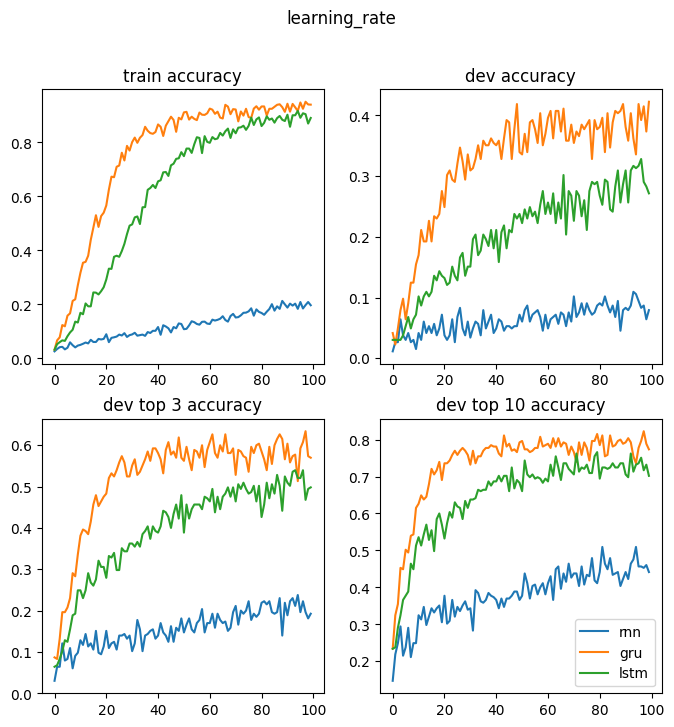

In [ ]:
figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()




ax[0].plot(rnn[1], label = 'rnn')
ax[1].plot(rnn[2], label = 'rnn')
ax[2].plot(rnn[3], label = 'rnn')
ax[3].plot(rnn[4], label = 'rnn')

ax[0].plot(gru[1], label = 'gru')
ax[1].plot(gru[2], label = 'gru')
ax[2].plot(gru[3], label = 'gru')
ax[3].plot(gru[4], label = 'gru')

ax[0].plot(lstm[1], label = 'lstm')
ax[1].plot(lstm[2], label = 'lstm')
ax[2].plot(lstm[3], label = 'lstm')
ax[3].plot(lstm[4], label = 'lstm')

ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')

plt.legend()

figure.suptitle('learning_rate')

# Deal with overfitting

In [ ]:
# regulization

In [ ]:
weight_decays = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]


seq_len = 8
hidden_size = 512
num_layers_ = 2
num_epochs = 60
batch_sizes = 32
learning_rate = 0.001

train_accs_list = []
dev_accs_list = []
dev_accs_top3_list = []
dev_accs_top10_list = []

for weight_decay in weight_decays:
  print(weight_decay)
  train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
  dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

  model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

  # losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []


  for epoch in range(num_epochs):
      print('weight_decay ', str(weight_decay), 'epoch ', str(epoch + 1), '/', str(num_epochs))

      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)
          arrays = arrays.to(device)

          # Forward pass
          outputs = model(arrays)
          loss = criterion(outputs, labels)
          # losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # if (i+1) % print_loss_every_step == 0:
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  train_accs_list.append(train_accs)
  dev_accs_list.append(dev_accs)
  dev_accs_top3_list.append(dev_accs_top3)
  dev_accs_top10_list.append(dev_accs_top10)


0.1
weight_decay  0.1 epoch  1 / 60
train Accuracy: 1.27
dev Accuracy: 0.38
dev top 3 Accuracy: 1.13
dev top 10 Accuracy: 6.42
weight_decay  0.1 epoch  2 / 60
train Accuracy: 1.87
dev Accuracy: 0.75
dev top 3 Accuracy: 1.89
dev top 10 Accuracy: 9.43
weight_decay  0.1 epoch  3 / 60
train Accuracy: 1.87
dev Accuracy: 0.75
dev top 3 Accuracy: 3.40
dev top 10 Accuracy: 8.68
weight_decay  0.1 epoch  4 / 60
train Accuracy: 1.87
dev Accuracy: 0.75
dev top 3 Accuracy: 3.40
dev top 10 Accuracy: 8.68
weight_decay  0.1 epoch  5 / 60
train Accuracy: 1.87
dev Accuracy: 0.75
dev top 3 Accuracy: 3.40
dev top 10 Accuracy: 9.81
weight_decay  0.1 epoch  6 / 60
train Accuracy: 1.87
dev Accuracy: 0.75
dev top 3 Accuracy: 3.40
dev top 10 Accuracy: 6.04
weight_decay  0.1 epoch  7 / 60
train Accuracy: 1.87
dev Accuracy: 0.75
dev top 3 Accuracy: 3.40
dev top 10 Accuracy: 7.17
weight_decay  0.1 epoch  8 / 60
train Accuracy: 1.87
dev Accuracy: 0.75
dev top 3 Accuracy: 3.02
dev top 10 Accuracy: 6.04
weight_decay

Text(0.5, 0.98, 'weight_decay')

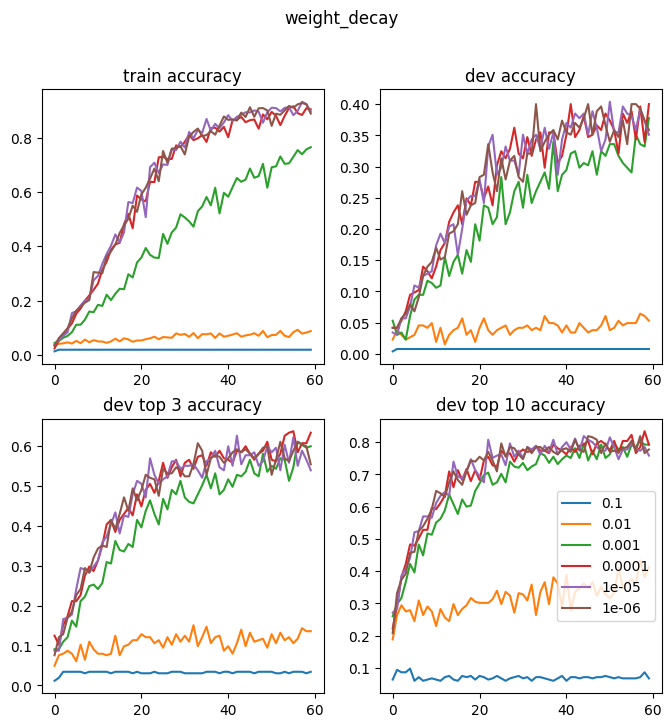

In [ ]:
figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()

for i, weight_decay in enumerate(weight_decays):
  ax[0].plot(train_accs_list[i], label = str(weight_decay))
  ax[1].plot(dev_accs_list[i], label = str(weight_decay))
  ax[2].plot(dev_accs_top3_list[i], label = str(weight_decay))
  ax[3].plot(dev_accs_top10_list[i], label = str(weight_decay))
  
ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')

plt.legend()

figure.suptitle('weight_decay')

In [ ]:
weight_decays = [0.001, 0.0001, 0.00001]


seq_len = 8
hidden_size = 512
num_layers_ = 2
num_epochs = 120
batch_sizes = 32
learning_rate = 0.001

train_accs_list = []
dev_accs_list = []
dev_accs_top3_list = []
dev_accs_top10_list = []

for weight_decay in weight_decays:
  print(weight_decay)
  train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
  dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

  model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

  # losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []


  for epoch in range(num_epochs):
      print('weight_decay ', str(weight_decay), 'epoch ', str(epoch + 1), '/', str(num_epochs))

      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)
          arrays = arrays.to(device)

          # Forward pass
          outputs = model(arrays)
          loss = criterion(outputs, labels)
          # losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # if (i+1) % print_loss_every_step == 0:
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  train_accs_list.append(train_accs)
  dev_accs_list.append(dev_accs)
  dev_accs_top3_list.append(dev_accs_top3)
  dev_accs_top10_list.append(dev_accs_top10)


0.001
weight_decay  0.001 epoch  1 / 120
train Accuracy: 2.07
dev Accuracy: 3.77
dev top 3 Accuracy: 7.55
dev top 10 Accuracy: 21.51
weight_decay  0.001 epoch  2 / 120
train Accuracy: 4.94
dev Accuracy: 4.15
dev top 3 Accuracy: 9.43
dev top 10 Accuracy: 23.40
weight_decay  0.001 epoch  3 / 120
train Accuracy: 6.87
dev Accuracy: 3.40
dev top 3 Accuracy: 10.57
dev top 10 Accuracy: 30.94
weight_decay  0.001 epoch  4 / 120
train Accuracy: 6.00
dev Accuracy: 5.28
dev top 3 Accuracy: 12.83
dev top 10 Accuracy: 37.74
weight_decay  0.001 epoch  5 / 120
train Accuracy: 10.01
dev Accuracy: 6.79
dev top 3 Accuracy: 15.47
dev top 10 Accuracy: 39.62
weight_decay  0.001 epoch  6 / 120
train Accuracy: 10.87
dev Accuracy: 5.28
dev top 3 Accuracy: 14.72
dev top 10 Accuracy: 45.28
weight_decay  0.001 epoch  7 / 120
train Accuracy: 12.47
dev Accuracy: 7.55
dev top 3 Accuracy: 18.11
dev top 10 Accuracy: 43.02
weight_decay  0.001 epoch  8 / 120
train Accuracy: 15.48
dev Accuracy: 9.43
dev top 3 Accuracy: 1

Text(0.5, 0.98, 'weight_decay')

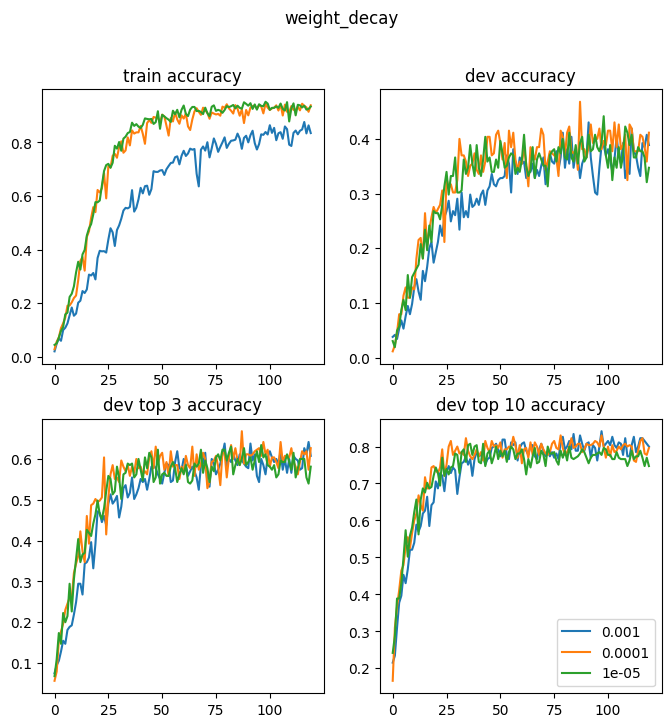

In [ ]:
figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()

for i, weight_decay in enumerate(weight_decays):
  ax[0].plot(train_accs_list[i], label = str(weight_decay))
  ax[1].plot(dev_accs_list[i], label = str(weight_decay))
  ax[2].plot(dev_accs_top3_list[i], label = str(weight_decay))
  ax[3].plot(dev_accs_top10_list[i], label = str(weight_decay))
  
ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')

plt.legend()

figure.suptitle('weight_decay')

In [ ]:
dropouts = [0, 0.1, 0.2, 0.4, 0.6]

seq_len = 8
hidden_size = 512
num_layers_ = 2
num_epochs = 60
batch_sizes = 32
learning_rate = 0.001

train_accs_list = []
dev_accs_list = []
dev_accs_top3_list = []
dev_accs_top10_list = []


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout = 0):
        super(RNN, self).__init__()
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, 
                          batch_first = True, dropout = dropout)
        self.foc = nn.Linear((hidden_size), (num_classes))

    def forward(self, x):
        x, h_n = self.gru(x)
        output = self.foc(h_n[-1])
        return output

for dropout in dropouts:
  print(dropout)
  train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
  dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

  model = RNN(input_size, hidden_size, num_layers, num_classes, dropout).double().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []


  for epoch in range(num_epochs):
      print('dropout ', str(dropout), 'epoch ', str(epoch + 1), '/', str(num_epochs))

      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)
          arrays = arrays.to(device)

          # Forward pass
          outputs = model(arrays)
          loss = criterion(outputs, labels)
          # losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # if (i+1) % print_loss_every_step == 0:
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  train_accs_list.append(train_accs)
  dev_accs_list.append(dev_accs)
  dev_accs_top3_list.append(dev_accs_top3)
  dev_accs_top10_list.append(dev_accs_top10)


0
dropout  0 epoch  1 / 60
train Accuracy: 2.67
dev Accuracy: 2.64
dev top 3 Accuracy: 7.17
dev top 10 Accuracy: 21.51
dropout  0 epoch  2 / 60
train Accuracy: 6.40
dev Accuracy: 5.28
dev top 3 Accuracy: 11.70
dev top 10 Accuracy: 30.94
dropout  0 epoch  3 / 60
train Accuracy: 6.40
dev Accuracy: 1.51
dev top 3 Accuracy: 12.08
dev top 10 Accuracy: 34.72
dropout  0 epoch  4 / 60
train Accuracy: 10.01
dev Accuracy: 6.79
dev top 3 Accuracy: 17.74
dev top 10 Accuracy: 38.87
dropout  0 epoch  5 / 60
train Accuracy: 11.47
dev Accuracy: 7.55
dev top 3 Accuracy: 19.25
dev top 10 Accuracy: 43.40
dropout  0 epoch  6 / 60
train Accuracy: 14.61
dev Accuracy: 9.81
dev top 3 Accuracy: 21.13
dev top 10 Accuracy: 49.43
dropout  0 epoch  7 / 60
train Accuracy: 18.41
dev Accuracy: 12.83
dev top 3 Accuracy: 24.91
dev top 10 Accuracy: 52.45
dropout  0 epoch  8 / 60
train Accuracy: 18.81
dev Accuracy: 10.19
dev top 3 Accuracy: 28.68
dev top 10 Accuracy: 53.96
dropout  0 epoch  9 / 60
train Accuracy: 23.68
d

Text(0.5, 0.98, 'dropout')

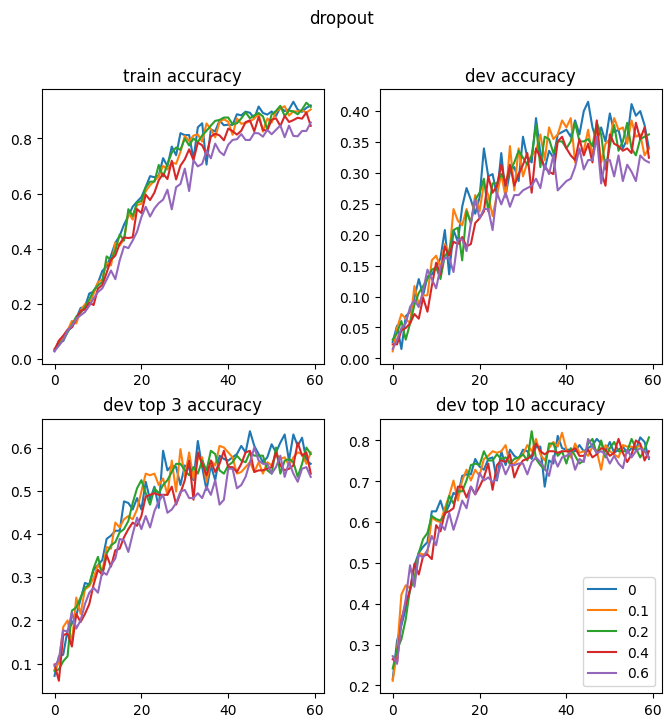

In [ ]:
figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()

for i, dropout in enumerate(dropouts):
  ax[0].plot(train_accs_list[i], label = str(dropout))
  ax[1].plot(dev_accs_list[i], label = str(dropout))
  ax[2].plot(dev_accs_top3_list[i], label = str(dropout))
  ax[3].plot(dev_accs_top10_list[i], label = str(dropout))
  
ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')

plt.legend()

figure.suptitle('dropout')

## Data augmentation

In [ ]:
import random

cof_shift = 0.1
# cof_vib = 0.01

def seq_len_filter(m, seq_len):
  b_len = m.shape[0]
  lucky_index = []
  for i in range(seq_len):
    lucky_index.append(random.randint(0, b_len-1))
  lucky_index.sort()

  new_m = m[lucky_index]
  # new_m = new_m.reshape((seq_len, -1))
  return new_m

def aug_filter(m, cof_shift):
  x_shift = (random.random() - 0.5) * cof_shift * 2
  y_shift = (random.random()-0.5) * cof_shift * 2
  z_shift = 0
  shift_ = [[np.array([x_shift, y_shift, z_shift])]] * 21
  shift_ = np.concatenate(shift_, axis = 0)

  new_m = []

  for i in range(m.shape[0]):
    two_hands = []
    for j in range(m.shape[1]):
      one_hand = m[i][j]
      # print(one_hand.shape)
      if one_hand.sum() != 0:
        one_hand += shift_
      two_hands.append([one_hand])
    two_hands = np.concatenate(two_hands, axis = 0)
    # print(two_hands.shape)
    new_m.append([two_hands])
  
  new_m = np.concatenate(new_m, axis = 0)
  # print(new_m.shape)
  
  return new_m



In [ ]:
from torch.utils.data import Dataset, DataLoader
import random
class Seq_len_dataset_aug(Dataset):
  def __init__(self, list_of_arrays, y, seq_len, cof_shift):
    self.list_of_arrays = list_of_arrays
    self.y = y
    self.seq_len = seq_len
    self.cof_shift = cof_shift

  def __len__(self):
    return len(self.list_of_arrays)
  
  def __getitem__(self, idx):
    array = self.list_of_arrays[idx]
    array = seq_len_filter(array, self.seq_len)
    if self.cof_shift != 0:
      array = aug_filter(array, self.cof_shift)
    array = array.reshape((seq_len, -1))
    label = self.y[idx]
    return (array, label)
 
train_dataset = Seq_len_dataset_aug(list_train, y_train, seq_len, cof_shift)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataset = Seq_len_dataset_aug(list_dev, y_dev, seq_len, cof_shift = 0)
dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)
test_dataset = Seq_len_dataset_aug(list_test, y_test, seq_len, cof_shift = 0)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
cof_shifts = [0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]


seq_len = 8
hidden_size = 512
num_layers_ = 2
num_epochs = 100
batch_sizes = 32
learning_rate = 0.001

train_accs_list = []
dev_accs_list = []
dev_accs_top3_list = []
dev_accs_top10_list = []

for cof_shift in cof_shifts:
  print(cof_shift)
  train_dataset = Seq_len_dataset_aug(list_train, y_train, seq_len, cof_shift)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dev_dataset = Seq_len_dataset_aug(list_dev, y_dev, seq_len, 0)
  dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

  model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []


  for epoch in range(num_epochs):
      print('cof_shift ', str(cof_shift), 'epoch ', str(epoch + 1), '/', str(num_epochs))

      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)
          arrays = arrays.to(device)

          # Forward pass
          outputs = model(arrays)
          loss = criterion(outputs, labels)
          # losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # if (i+1) % print_loss_every_step == 0:
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              arrays = arrays.to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  train_accs_list.append(train_accs)
  dev_accs_list.append(dev_accs)
  dev_accs_top3_list.append(dev_accs_top3)
  dev_accs_top10_list.append(dev_accs_top10)


0
cof_shift  0 epoch  1 / 100
train Accuracy: 3.07
dev Accuracy: 1.89
dev top 3 Accuracy: 7.92
dev top 10 Accuracy: 22.26
cof_shift  0 epoch  2 / 100
train Accuracy: 5.00
dev Accuracy: 5.28
dev top 3 Accuracy: 10.57
dev top 10 Accuracy: 31.32
cof_shift  0 epoch  3 / 100
train Accuracy: 8.87
dev Accuracy: 5.28
dev top 3 Accuracy: 15.47
dev top 10 Accuracy: 38.11
cof_shift  0 epoch  4 / 100
train Accuracy: 11.07
dev Accuracy: 5.28
dev top 3 Accuracy: 15.09
dev top 10 Accuracy: 42.26
cof_shift  0 epoch  5 / 100
train Accuracy: 13.61
dev Accuracy: 6.79
dev top 3 Accuracy: 20.38
dev top 10 Accuracy: 47.92
cof_shift  0 epoch  6 / 100
train Accuracy: 13.34
dev Accuracy: 9.43
dev top 3 Accuracy: 20.75
dev top 10 Accuracy: 47.17
cof_shift  0 epoch  7 / 100
train Accuracy: 18.35
dev Accuracy: 12.45
dev top 3 Accuracy: 27.55
dev top 10 Accuracy: 52.83
cof_shift  0 epoch  8 / 100
train Accuracy: 20.41
dev Accuracy: 10.94
dev top 3 Accuracy: 26.79
dev top 10 Accuracy: 53.21
cof_shift  0 epoch  9 / 

Text(0.5, 0.98, 'cof_shift')

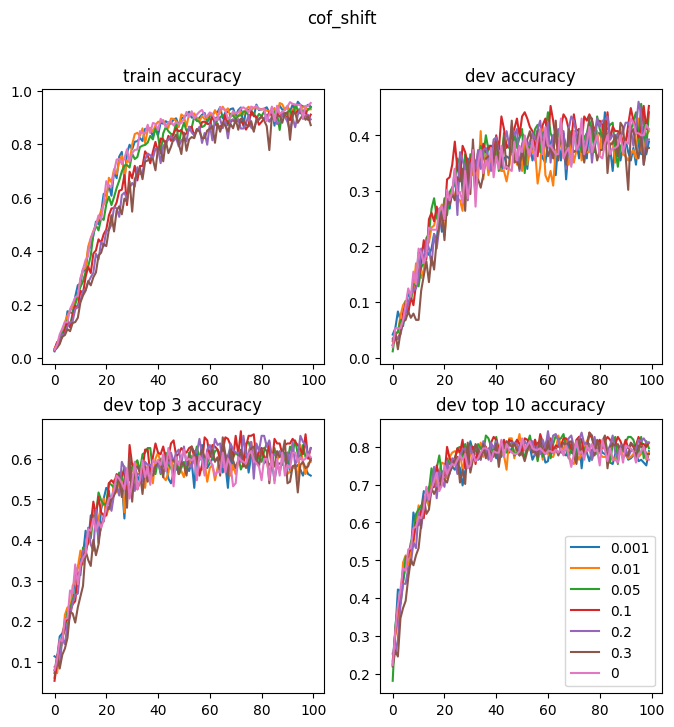

In [ ]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()

for i, cof_shift in enumerate(cof_shifts[1:]):
  ax[0].plot(train_accs_list[i+1], label = str(cof_shift))
  ax[1].plot(dev_accs_list[i+1], label = str(cof_shift))
  ax[2].plot(dev_accs_top3_list[i+1], label = str(cof_shift))
  ax[3].plot(dev_accs_top10_list[i+1], label = str(cof_shift))

cof_shift = 0
ax[0].plot(train_accs_list[0], label = str(cof_shift))
ax[1].plot(dev_accs_list[0], label = str(cof_shift))
ax[2].plot(dev_accs_top3_list[0], label = str(cof_shift))
ax[3].plot(dev_accs_top10_list[0], label = str(cof_shift))

ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')

plt.legend()

figure.suptitle('cof_shift')

Text(0.5, 0.98, 'cof_shift')

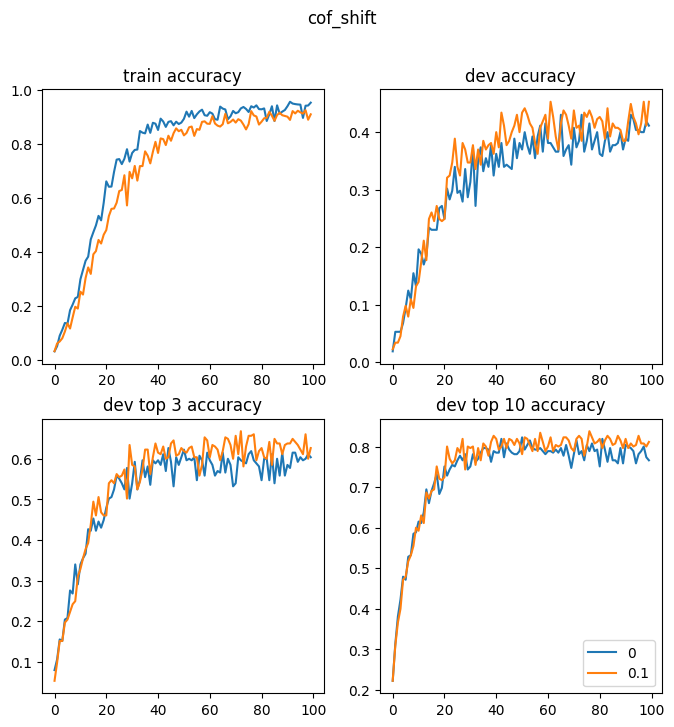

In [ ]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()



cof_shift = 0
ax[0].plot(train_accs_list[0], label = str(cof_shift))
ax[1].plot(dev_accs_list[0], label = str(cof_shift))
ax[2].plot(dev_accs_top3_list[0], label = str(cof_shift))
ax[3].plot(dev_accs_top10_list[0], label = str(cof_shift))


cof_shift = 0.1
ax[0].plot(train_accs_list[4], label = str(cof_shift))
ax[1].plot(dev_accs_list[4], label = str(cof_shift))
ax[2].plot(dev_accs_top3_list[4], label = str(cof_shift))
ax[3].plot(dev_accs_top10_list[4], label = str(cof_shift))

ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')

plt.legend()

figure.suptitle('cof_shift')

# Final training

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
data_path = '/content/drive/MyDrive/EE8101_Deep_Learning/dataset.pkl'
data_input = open(data_path, 'rb')
read_data = pickle.load(data_input)
data_input.close()

In [ ]:
label_list = read_data[0]
array_list = read_data[1]

In [ ]:
# path = '/content/drive/MyDrive/EE8101_Deep_Learning/NaN_to_Zero_Arrays'
# lst = os.listdir(path)

# label_list = []

# for a in tqdm(lst):
#   m = np.load(path + '/' + a)
#   word = a.split('_')[1].split('.')[0]
#   label_list.append(word)
#   array_list.append(m)

In [ ]:
class Lang:
    def __init__(self, name):
        self.name = name #language name
        self.word2index = {}    #word to index
        self.word2count = {}    #count of each word
        self.index2word = {} #index to word
        self.n_words = 0 # total number of words
      

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words #get the index of the current word
            self.word2count[word] = 1   #initialise the count of the current word as 1
            self.index2word[self.n_words] = word #update index to word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def index2word_(index):
  if type(index) is list:
    ans = []
    for idx in index:
      ans.append(index2word_(idx))
    return ans
  elif isinstance(index, int):
    return index2word_(index)

def index2word_(idx):
  return hand_lang.index2word[idx]


In [ ]:
import numpy as np
hand_lang = Lang('hand')
for w in label_list:
  hand_lang.index_word(w)
print(hand_lang.word2index)
print(hand_lang.word2count)

y = []
for w in label_list:
  i = hand_lang.word2index[w]
  y.append(i)

y = np.array(y)

{'cry': 0, 'dance': 1, 'decide': 2, 'dog': 3, 'doctor': 4, 'door': 5, 'drink': 6, 'eat': 7, 'enjoy': 8, 'family': 9, 'fine': 10, 'finish': 11, 'fish': 12, 'full': 13, 'go': 14, 'graduate': 15, 'hat': 16, 'hearing': 17, 'help': 18, 'how': 19, 'kiss': 20, 'last': 21, 'language': 22, 'later': 23, 'laugh': 24, 'learn': 25, 'letter': 26, 'man': 27, 'many': 28, 'meet': 29, 'mother': 30, 'need': 31, 'no': 32, 'now': 33, 'orange': 34, 'paint': 35, 'paper': 36, 'pink': 37, 'all': 38, 'apple': 39, 'before': 40, 'blue': 41, 'book': 42, 'but': 43, 'candy': 44, 'color': 45, 'computer': 46, 'cook': 47, 'deaf': 48, 'forget': 49, 'like': 50, 'play': 51, 'purple': 52, 'right': 53, 'study': 54, 'teacher': 55, 'walk': 56, 'want': 57, 'water': 58, 'white': 59, 'who': 60, 'woman': 61, 'wrong': 62, 'year': 63, 'yellow': 64, 'yes': 65, 'basketball': 66, 'bird': 67, 'black': 68, 'brown': 69, 'can': 70, 'cat': 71, 'city': 72, 'cool': 73, 'corn': 74, 'cow': 75, 'dark': 76, 'give': 77, 'hot': 78, 'pizza': 79, 'p

In [ ]:
lmao = {}
for i in hand_lang.index2word:
    lmao[str(i)] = hand_lang.index2word[i]

In [ ]:
lmao

{'0': 'cry',
 '1': 'dance',
 '10': 'fine',
 '100': 'work',
 '101': 'same',
 '102': 'shirt',
 '103': 'tell',
 '104': 'thanksgiving',
 '105': 'accident',
 '106': 'bed',
 '107': 'bowling',
 '108': 'call',
 '109': 'cheat',
 '11': 'finish',
 '110': 'check',
 '12': 'fish',
 '13': 'full',
 '14': 'go',
 '15': 'graduate',
 '16': 'hat',
 '17': 'hearing',
 '18': 'help',
 '19': 'how',
 '2': 'decide',
 '20': 'kiss',
 '21': 'last',
 '22': 'language',
 '23': 'later',
 '24': 'laugh',
 '25': 'learn',
 '26': 'letter',
 '27': 'man',
 '28': 'many',
 '29': 'meet',
 '3': 'dog',
 '30': 'mother',
 '31': 'need',
 '32': 'no',
 '33': 'now',
 '34': 'orange',
 '35': 'paint',
 '36': 'paper',
 '37': 'pink',
 '38': 'all',
 '39': 'apple',
 '4': 'doctor',
 '40': 'before',
 '41': 'blue',
 '42': 'book',
 '43': 'but',
 '44': 'candy',
 '45': 'color',
 '46': 'computer',
 '47': 'cook',
 '48': 'deaf',
 '49': 'forget',
 '5': 'door',
 '50': 'like',
 '51': 'play',
 '52': 'purple',
 '53': 'right',
 '54': 'study',
 '55': 'teacher'

In [ ]:
import json
f = open('/content/drive/MyDrive/EE8101_Deep_Learning/word_list_111.json', 'wb')
json.dump(lmao, f)
f.close()

In [ ]:
from sklearn.model_selection import train_test_split
def train_test_split2(array_list, y, train_test_ratio):
  list_train = []
  list_test = []
  y_train = []
  y_test = []
  len_label = len(set(y))
  video = {}
  for i in range(len_label):
    video[i] = []
  for value, label in zip(array_list, y):
    video[label].append(value)
  for i in range(len_label):
    count = 0
    for x in video[i]:
      if count == train_test_ratio:
        list_test.append(np.array(x))
        y_test.append(i)
        count = 0
      else:
        list_train.append(np.array(x))
        y_train.append(i)
        count = count + 1
  list_train = np.array(list_train)
  list_test = np.array(list_test)
  y_train = np.array(y_train)
  y_test = np.array(y_test)
  return list_train, list_test, y_train, y_test

list_train, list_test, y_train, y_test =  train_test_split2(array_list, y, train_test_ratio = 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
from torch.utils.data import Dataset, DataLoader
import random
from copy import deepcopy

cof_shift = 0.1
# cof_vib = 0.01

def seq_len_filter(m, seq_len):
  b_len = m.shape[0]
  lucky_index = []
  for i in range(seq_len):
    lucky_index.append(random.randint(0, b_len-1))
  lucky_index.sort()

  new_m = m[lucky_index]
  # new_m = new_m.reshape((seq_len, -1))
  return new_m

def aug_filter(m, cof_shift):
  x_shift = (random.random() - 0.5) * cof_shift * 2
  y_shift = (random.random() - 0.5) * cof_shift * 2
  z_shift = 0
  shift_ = [[np.array([x_shift, y_shift, z_shift])]] * 21
  shift_ = np.concatenate(shift_, axis = 0)

  new_m = []

  for i in range(m.shape[0]):
    two_hands = []
    for j in range(m.shape[1]):
      one_hand = m[i][j]
      # print(one_hand.shape)
      if one_hand.sum() != 0:
        one_hand += shift_
      two_hands.append([one_hand])
    two_hands = np.concatenate(two_hands, axis = 0)
    # print(two_hands.shape)
    new_m.append([two_hands])
  
  new_m = np.concatenate(new_m, axis = 0)
  # print(new_m.shape)
  
  return new_m

def mirror_filter(m): #prob = 0.5

  if random.random() <= 0.5:
    return m


  #mirror
  mm = deepcopy(m)

  mm[:, [0, 1], :, :] = mm[:, [1, 0], :, :]

  # x_mirror = 1
  # y_shift = 0
  # z_shift = 0
  # shift_ = [[np.array([x_mirror, y_shift, z_shift])]] * 21
  # shift_ = np.concatenate(shift_, axis = 0)

  new_m = []

  for i in range(mm.shape[0]):
    two_hands = []
    for j in range(mm.shape[1]):
      one_hand = mm[i][j]
      # print(one_hand.shape)
      if one_hand.sum() != 0:
        one_hand[:, 0] = 1 - one_hand[:, 0]
      two_hands.append([one_hand])
    two_hands = np.concatenate(two_hands, axis = 0)
    # print(two_hands.shape)
    new_m.append([two_hands])
  
  new_m = np.concatenate(new_m, axis = 0)
  # print(new_m.shape)

  return new_m


class Seq_len_dataset_aug(Dataset):
  def __init__(self, list_of_arrays, y, seq_len, cof_shift):
    self.list_of_arrays = list_of_arrays
    self.y = y
    self.seq_len = seq_len
    self.cof_shift = cof_shift

  def __len__(self):
    return len(self.list_of_arrays)
  
  def __getitem__(self, idx):
    array = self.list_of_arrays[idx]
    array = seq_len_filter(array, self.seq_len)
    
    if self.cof_shift != 0:
      array = aug_filter(array, self.cof_shift)
      # array = mirror_filter(array)
    array = array.reshape((seq_len, -1))
    
    label = self.y[idx]
    return (array, label)


In [ ]:
# mm = list_train[0]
# mirror_filter(mm)[0], mm[0]

In [ ]:
# mm = list_train[0]
# mm[0]

## Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def topk_correct(outputs, labels, topk):
  correct = 0
  outputs = outputs.topk(topk, dim = -1).indices
  for i, label in enumerate(labels):
    # print(outputs[i])
    if label in outputs[i]:
      
      correct += 1
  return correct

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.foc = nn.Linear((hidden_size), (num_classes))

    def forward(self, x):
        x, h_n = self.gru(x)
        output = self.foc(h_n[-1])
        return output

In [ ]:
train_accs = []
test_accs = []
test_accs_top3 = []
test_accs_top10 = []


cof_shift = 0.1
input_size = 2 * 21 * 3
seq_len = 8
hidden_size = 512
num_layers = 2
num_epochs = 100
batch_size = 32
learning_rate = 0.001
num_classes = 111

train_dataset = Seq_len_dataset_aug(list_train, y_train, seq_len, cof_shift)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Seq_len_dataset_aug(list_test, y_test, seq_len, cof_shift = 0)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    print('cof_shift ', str(cof_shift), 'epoch ', str(epoch + 1), '/', str(num_epochs))

    for i, (arrays, labels) in enumerate(train_loader):
        
        labels = labels.to(torch.long).to(device)
        arrays = arrays.to(device)

        # Forward pass
        outputs = model(arrays)
        loss = criterion(outputs, labels)
        # losses.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # if (i+1) % print_loss_every_step == 0:
          # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
    
    with torch.no_grad():
        total = 0
        total_correct = 0
        for i, (arrays, labels) in enumerate(train_loader):
            labels = labels.to(torch.long).to(device)
            arrays = arrays.to(device)
            # Forward pass
            outputs = model(arrays)
            outputs = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(outputs)
            total_correct += (outputs == labels).sum().item()

        train_acc = total_correct / total
        train_accs.append(train_acc)

        print(f"train Accuracy: {total_correct / total * 100:.2f}")

    with torch.no_grad():
        total = 0
        total_correct = 0
        total_top3_correct = 0
        total_top10_correct = 0
        for i, (arrays, labels) in enumerate(test_loader):
            labels = labels.to(torch.long).to(device)
            arrays = arrays.to(device)
            # Forward pass
            outputs = model(arrays)
            preds = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(preds)
            total_correct += (preds == labels).sum().item()
            total_top3_correct += topk_correct(outputs, labels, 3)
            total_top10_correct += topk_correct(outputs, labels, 10)


        test_acc = total_correct / total
        test_accs.append(test_acc)
        test_accs_top3.append(total_top3_correct / total)
        test_accs_top10.append(total_top10_correct / total)

        print(f"test Accuracy: {total_correct / total * 100:.2f}")
        print(f"test top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
        print(f"test top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

cof_shift  0.1 epoch  1 / 100
train Accuracy: 2.44
test Accuracy: 1.71
test top 3 Accuracy: 6.84
test top 10 Accuracy: 21.37
cof_shift  0.1 epoch  2 / 100
train Accuracy: 4.88
test Accuracy: 5.13
test top 3 Accuracy: 13.68
test top 10 Accuracy: 37.61
cof_shift  0.1 epoch  3 / 100
train Accuracy: 7.65
test Accuracy: 4.27
test top 3 Accuracy: 13.68
test top 10 Accuracy: 36.75
cof_shift  0.1 epoch  4 / 100
train Accuracy: 8.52
test Accuracy: 9.40
test top 3 Accuracy: 18.80
test top 10 Accuracy: 47.86
cof_shift  0.1 epoch  5 / 100
train Accuracy: 10.15
test Accuracy: 11.97
test top 3 Accuracy: 23.08
test top 10 Accuracy: 48.72
cof_shift  0.1 epoch  6 / 100
train Accuracy: 12.86
test Accuracy: 10.26
test top 3 Accuracy: 32.48
test top 10 Accuracy: 52.14
cof_shift  0.1 epoch  7 / 100
train Accuracy: 14.70
test Accuracy: 12.82
test top 3 Accuracy: 29.91
test top 10 Accuracy: 64.10
cof_shift  0.1 epoch  8 / 100
train Accuracy: 15.90
test Accuracy: 16.24
test top 3 Accuracy: 31.62
test top 10 A

Text(0.5, 1.0, 'train and test accuracy')

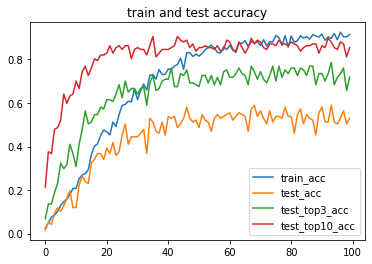

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label = 'train_acc')
plt.plot(test_accs, label = 'test_acc')
plt.plot(test_accs_top3, label = 'test_top3_acc')
plt.plot(test_accs_top10, label = 'test_top10_acc')
plt.legend()
plt.title('train and test accuracy')

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/EE8101/' + 'final_model1.pt'
torch.save(model.state_dict(), model_path)

# Model for demostration

In [ ]:
model(torch)